In [3]:
import pandas as pd

df = pd.read_csv("species_occurrence.csv")
print(df.info())
print(df.head())

C:\Users\Felix Hook\AppData\Local\Temp\ipykernel_16796\12118433.py:3: DtypeWarning: Columns (10,14,20,21,36,37,38,39,40,41,44,50,127,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,231) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("species_occurrence.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68602 entries, 0 to 68601
Columns: 233 entries, key to acceptedNameUsageID
dtypes: float64(2), int64(6), object(225)
memory usage: 122.0+ MB
None
          key                            datasetKey  \
0  4510070577  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1  4512238680  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2  4516323776  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3  4597188954  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4  4599839441  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

                       publishingOrgKey                       installationKey  \
0  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
1  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
2  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
3  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-00145eb45e9a   
4  28eb1a3f-1c15-4a95-931a-4af90ecb574d  997448a8-f762-11e1-a439-001

In [4]:
import numpy as np
import re

# Drop missing coordinates
df = df.dropna(subset=["decimalLatitude", "decimalLongitude"])

# Try parsing eventDate first
df["eventDate_parsed"] = pd.to_datetime(df["eventDate"], errors="coerce", utc=True)

# Where parsing failed, try constructing from year/month/day columns
mask_missing = df["eventDate_parsed"].isna()

if "year" in df.columns:
    years = pd.to_numeric(df.loc[mask_missing, "year"], errors="coerce")
    months = pd.to_numeric(df.loc[mask_missing, "month"], errors="coerce").fillna(1).astype(int)
    days = pd.to_numeric(df.loc[mask_missing, "day"], errors="coerce").fillna(1).astype(int)

    rebuilt_dates = pd.to_datetime(
        dict(year=years, month=months, day=days), errors="coerce", utc=True
    )

    df.loc[mask_missing, "eventDate_parsed"] = rebuilt_dates



In [5]:
import re

# Function to extract the first 4-digit year starting with "20" from any string
def extract_year(val):
    if pd.isna(val):
        return None
    match = re.search(r"(20\d{2})", str(val))
    return int(match.group(1)) if match else None

# Look for misplaced years in "month" and "stateProvince"
years_from_month = df["month"].map(extract_year)
years_from_state = df["stateProvince"].map(extract_year)

# Priority: month first, then stateProvince
misplaced_years = years_from_month.combine_first(years_from_state)

# Overwrite eventDate_parsed if a misplaced year exists
mask_has_year = misplaced_years.notna()

df.loc[mask_has_year, "eventDate_parsed"] = pd.to_datetime(
    misplaced_years[mask_has_year].astype(int).astype(str),
    format="%Y", errors="coerce", utc=True
)

# Clear out the wrong entries
df.loc[years_from_month.notna(), "month"] = np.nan
df.loc[years_from_state.notna(), "stateProvince"] = np.nan

# Rebuild cleaned date
df["eventDate_clean"] = df["eventDate_parsed"]
df["year_clean"] = df["eventDate_clean"].dt.year
df["month_clean"] = df["eventDate_clean"].dt.month
df["day_clean"] = df["eventDate_clean"].dt.day

In [6]:
print("Total records:", len(df))
print("Valid eventDate_clean:", df["eventDate_clean"].notna().sum())
print("Missing eventDate_clean:", df["eventDate_clean"].isna().sum())

Total records: 68361
Valid eventDate_clean: 68302
Missing eventDate_clean: 59


[Text(0, 0, '2000'),
 Text(1, 0, '2001'),
 Text(2, 0, '2002'),
 Text(3, 0, '2003'),
 Text(4, 0, '2004'),
 Text(5, 0, '2005'),
 Text(6, 0, '2006'),
 Text(7, 0, '2007'),
 Text(8, 0, '2008'),
 Text(9, 0, '2009'),
 Text(10, 0, '2010'),
 Text(11, 0, '2011'),
 Text(12, 0, '2012'),
 Text(13, 0, '2013'),
 Text(14, 0, '2014'),
 Text(15, 0, '2015'),
 Text(16, 0, '2016'),
 Text(17, 0, '2017'),
 Text(18, 0, '2018'),
 Text(19, 0, '2019'),
 Text(20, 0, '2020'),
 Text(21, 0, '2021'),
 Text(22, 0, '2022'),
 Text(23, 0, '2023'),
 Text(24, 0, '2024')]

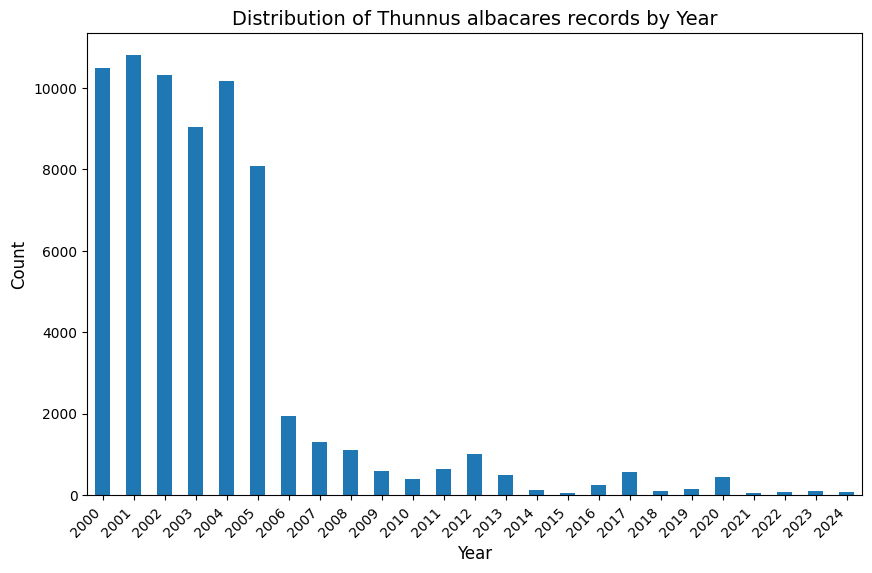

In [11]:
import matplotlib.pyplot as plt

series = (df["year_clean"][
    (df["year_clean"] >= 2000) & (df["year_clean"] <= 2024)]
    .astype(int) 
    .value_counts()
    .sort_index()
)

# create plot and axes
ax = series.plot(kind="bar", figsize = (10,6))

# axis labels
ax.set_xlabel("Year", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Distribution of Thunnus albacares records by Year", fontsize = 14)

# rotate x_labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


In [10]:
print(df[["decimalLatitude", "decimalLongitude"]].dtypes)
print(df[["decimalLatitude", "decimalLongitude"]].head())

df["decimalLatitude"] = pd.to_numeric(df["decimalLatitude"], errors="coerce")
df["decimalLongitude"] = pd.to_numeric(df["decimalLongitude"], errors="coerce")


df = df.dropna(subset=["decimalLatitude", "decimalLongitude"])


decimalLatitude     float64
decimalLongitude    float64
dtype: object
   decimalLatitude  decimalLongitude
0        19.099756       -104.346855
1       -11.705752         43.249075
2        39.649016        -72.288256
3        19.195954       -104.682498
4        18.946743         72.835772


In [11]:
import folium
m = folium.Map(location=[0,0], zoom_start=2)
for _, row in df.sample(500).iterrows():
    folium.CircleMarker([row["decimalLatitude"], row["decimalLongitude"]],
                        radius=2, color="blue").add_to(m)
m.save("map.html")